In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
import matplotlib.pyplot as plt
from keras import Model

Building the class for Lasso regression

Implementation:

Generating and Importing dataframe

In [2]:
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
import sklearn.datasets as dt

X,Y = dt.load_diabetes(return_X_y=True)

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2) # Generating train and test dataset

Lasso regression using scikit-learn library

C:\Users\patel\AppData\Local\Temp\ipykernel_14788\4247635128.py:13: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model_lasso.fit(X_train,Y_train)    # training the model
e:\Lectures\Arbeit\Sensorics\sens\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
e:\Lectures\Arbeit\Sensorics\sens\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.250e+05, tolerance: 2.112e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


   r2_score   intercept          0           1           2           3  \
0  0.560238  154.832237  22.518386 -279.401124  547.225740  317.985877   
1  0.565161  154.810620  20.814891 -265.916335  552.761356  313.232058   
2  0.565793  154.812159   0.000000 -189.107384  547.338967  278.707875   
3  0.392535  154.712033   0.000000   -0.000000  377.912296    0.000000   
4 -0.009536  153.614731   0.000000    0.000000    0.000000    0.000000   

            4           5           6           7           8          9  \
0 -932.941141  640.394698  117.658708  115.001526  786.042358  60.931963   
1 -486.506472  286.711222  -70.149086   59.571859  622.426600  61.022313   
2  -37.979640   -0.000000 -209.707569    0.000000  447.380768  32.445761   
3    0.000000    0.000000   -0.000000    0.000000  281.367747   0.000000   
4    0.000000    0.000000   -0.000000    0.000000    0.000000   0.000000   

   lamda  
0   0.00  
1   0.01  
2   0.10  
3   1.00  
4  10.00  


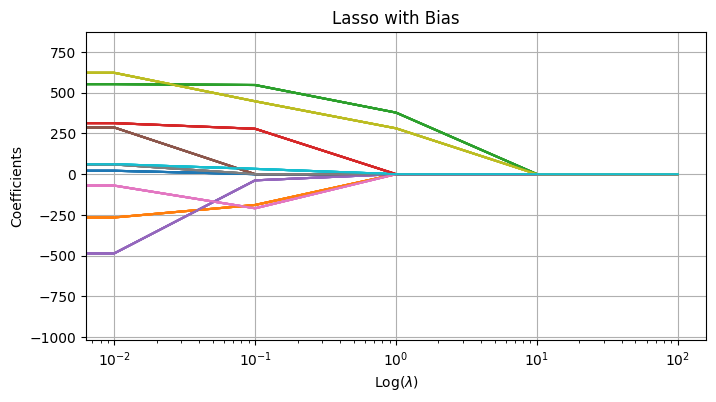

In [3]:
from sklearn.linear_model import Lasso
from importlib import reload
plt = reload(plt)

lamda = [0,0.01,0.1,1,10,100]   # an array with differnet values of tuning parameter

cf_lasso = []   # array of co-efficients for different lamda
r2_scores_lasso = []    # array of r2 scores for different lamda
intercept=[]    # array of biases for different lamda

for i in lamda:
    model_lasso = Lasso(alpha = i)
    model_lasso.fit(X_train,Y_train)    # training the model

    cf_lasso.append(model_lasso.coef_.tolist())
    intercept.append(model_lasso.intercept_)
    ym_lasso = model_lasso.predict(X_test)  # Generating model output
    r2_scores_lasso.append(r2_score(Y_test,ym_lasso))

# Genarating daframe with lamdas, r2_score, bias and co-efficients
df_lasso = pd.DataFrame(cf_lasso)
df_lasso['lamda'] = lamda
df_lasso.set_index('lamda')
df_lasso.insert(loc=0,column= 'r2_score',value=r2_scores_lasso)
df_lasso.insert(loc=1,column= 'intercept',value=intercept)

print(df_lasso.head())

# Plotting diffenent values of lamda vs co-efficients
nwl,_ = np.array(cf_lasso).shape
plt.figure(figsize = (8,4))

for i in range(nwl):
    plt.plot(lamda, cf_lasso)

plt.xlabel('Log($\\lambda$)')
plt.xscale('log')
plt.ylabel('Coefficients')
plt.title('Lasso with Bias')
plt.axis('tight')
plt.grid()
plt.show()

Tuning hyperparamter for the best result

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
pipleline = Pipeline([('scaler',StandardScaler()),('model',Lasso())])
search = GridSearchCV(pipleline,{'model__alpha': np.array(lamda)},cv = 10, scoring = 'neg_mean_squared_error',return_train_score = False)
search.fit(X_train,Y_train)
print(search.best_params_)
search.best_estimator_[1].coef_

{'model__alpha': 1.0}


e:\Lectures\Arbeit\Sensorics\sens\lib\site-packages\sklearn\pipeline.py:382: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
e:\Lectures\Arbeit\Sensorics\sens\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
e:\Lectures\Arbeit\Sensorics\sens\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.676e+05, tolerance: 1.901e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV 

array([  0.28548942, -10.95649613,  25.82403453,  14.03118595,
        -4.21734877,  -0.        , -10.69139618,   0.        ,
        22.84304611,   2.4656477 ])

Creating class Coordinate Descent with Bias

In [5]:
class CoordinateDescentLassoWithBias(Model):
    def __init__(self, alpha, epoch = 1000):
        self.alpha = alpha  # tuning parameter(penalty term)  
        self.epoch =  epoch  # No. of iterations (default = 1000)
        self.coef = None    # Weights or Co-eficients
        self.bias = None    # Bias or intercept

    # Generating soft threshold function to find the value of weights
    def soft_threshold(self,rho,lamda):
        if rho < - lamda:
            return rho + lamda
        elif rho > lamda:
            return rho - lamda
        else: 
            return 0


    def fit(self, X, y):
        X = np.column_stack((np.ones(len(X)), X))   # Training features
        m,n = X.shape
        beta = np.zeros(n)  # array of bias and weights

        for iteration in range(self.epoch):
                        
            for j in range(n):
                start = 1
                beta[j] = 0.0
                error  = y - np.dot(X, beta)
                rho = np.dot(X[:, j], error )
                lamda  = self.alpha*m

                beta[j] = self.soft_threshold(rho , lamda ) / (X[:, j]**2).sum()
        
    
        beta[0] = np.sum(y - np.dot(X[:, 1:], beta[1:])) / (X.shape[0])
        self.coef = beta[1:]
        self.bias = beta[0]
        
        return self

    # Predicting model output
    def predict(self, X):
        y = np.dot(X, self.coef) + self.bias
                
        return y

    # Normalized root mean square error
    def NRMSE(self,y,ym):
        # y: Process output, ym: Model output or predictions
        error = np.zeros(len(y))

        for i in range(len(y)):
            error[i] = (y[i]-ym[i])**2
            
        return np.sqrt(np.mean((error)/np.char.chararray.var(y)))


Implemantation of Coordinate Descent with Bias

      NRMSE  r2_score        bias          0           1           2  \
0  0.663146  0.560238  154.832237  22.518386 -279.401124  547.225740   
1  0.659434  0.565147  154.810669  20.796979 -265.940576  552.707872   
2  0.658925  0.565818  154.811284   0.000000 -189.079095  547.164682   
3  0.779626  0.392183  154.709693   0.000000    0.000000  376.865270   
4  1.004757 -0.009536  153.614731   0.000000    0.000000    0.000000   

            3           4           5           6           7           8  \
0  317.985877 -932.941141  640.394698  117.658708  115.001526  786.042358   
1  313.259853 -489.784843  289.254939  -68.682323   60.030751  623.620674   
2  278.842594  -38.012702    0.000000 -209.762330    0.000000  447.330053   
3    0.020052    0.000000    0.000000    0.000000    0.000000  281.400533   
4    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   

           9  lamda  
0  60.931963   0.00  
1  61.017802   0.01  
2  32.529017   0.10  
3   0.000000   1

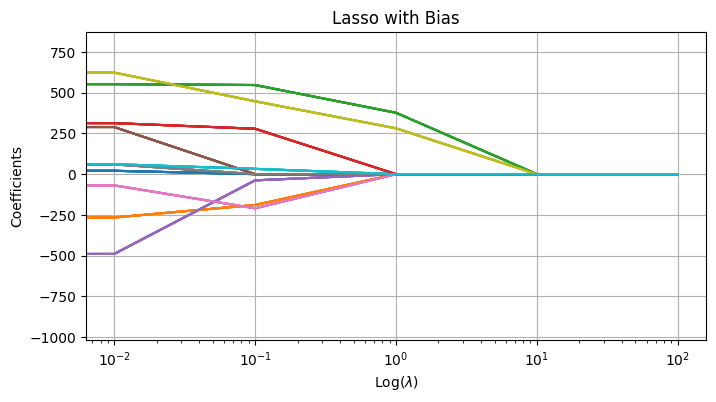

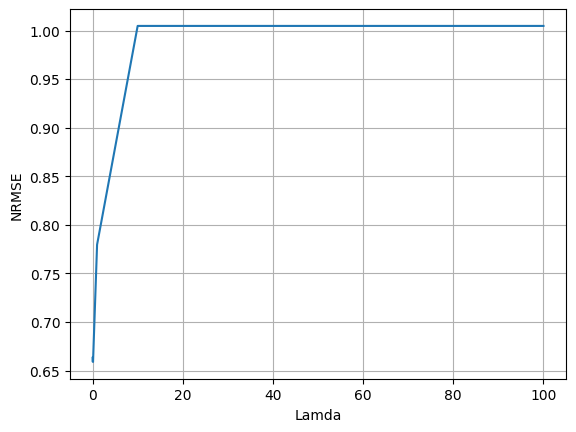

In [6]:
w_w = []
r2_scores_w= []
NRMSE_w = []
bias = []


for i in lamda:
    model = CoordinateDescentLassoWithBias(i)
    model.fit(X_train,Y_train)
    w_w.append(model.coef)
    bias.append(model.bias)
    ym_w = model.predict(X_test)
    r2_scores_w.append(r2_score(Y_test,ym_w))
    NRMSE_w.append(model.NRMSE(Y_test,ym_w))


df_w = pd.DataFrame(w_w)
df_w['lamda'] = lamda
df_w.set_index('lamda')

df_w.insert(loc=0,column= 'r2_score',value=r2_scores_w)
df_w.insert(loc=0,column= 'NRMSE',value=NRMSE_w)
df_w.insert(loc=2,column= 'bias',value=bias)

print(df_w.head())

nw,_ = np.array(w_w).shape
plt.figure(figsize = (8,4))

for i in range(nw):
    plt.plot(lamda, w_w)

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('Coefficients')
plt.title('Lasso with Bias')
plt.axis('tight')
plt.grid()
plt.show()

plt.plot(lamda,NRMSE_w)
plt.xlabel('Lamda')
plt.ylabel('NRMSE')
plt.axis('tight')
plt.grid()
plt.show()

Creating class Coordinate Descent without Bias

In [7]:
class CoordinateDescentLassoWithoutBias(CoordinateDescentLassoWithBias):
    def __init__(self, alpha, epoch= 1000):
        self.alpha = alpha  
        self.epoch = epoch  
        self.coef = None 

    def fit(self, X, y):
        m,n = X.shape
        beta = np.zeros(n)        

        for iteration in range(self.epoch):
            
            for j in range(n):
                beta[j] = 0.0
                error = y - np.dot(X, beta)
                rho = np.dot(X[:, j], error)
                lamda = self.alpha*m

                beta[j] = self.soft_threshold( rho, lamda) / (X[:, j]**2).sum()        
    
        self.coef = beta
        
        return self

    def predict(self, X):        
        y = np.dot(X, self.coef)        
        return y

Implementation of Coordinate Descent without Bias

      NRMSE  r2_score          0           1           2           3  \
0  2.067712 -3.275432 -13.992074 -256.685018  277.252574  534.817754   
1  2.067830 -3.275923  -4.675580 -244.907557  282.970091  527.500480   
2  2.059695 -3.242344   0.000000 -165.679075  270.029311  475.109052   
3  2.091991 -3.376426   0.000000    0.000000  142.683316  222.075644   
4  2.183899 -3.769417   0.000000    0.000000    0.000000    0.000000   

            4           5           6           7           8           9  \
0 -799.673718  363.660599  116.326715  420.056939  538.113061  195.923448   
1 -354.556580    9.864263  -71.717670  365.650831  373.369802  193.810123   
2  -95.413143    0.000000 -268.185196   79.786017  329.249448  165.224127   
3    0.000000    0.000000  -50.078008    1.264586  216.924316    0.000000   
4    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   

   lamda  
0   0.00  
1   0.01  
2   0.10  
3   1.00  
4  10.00  


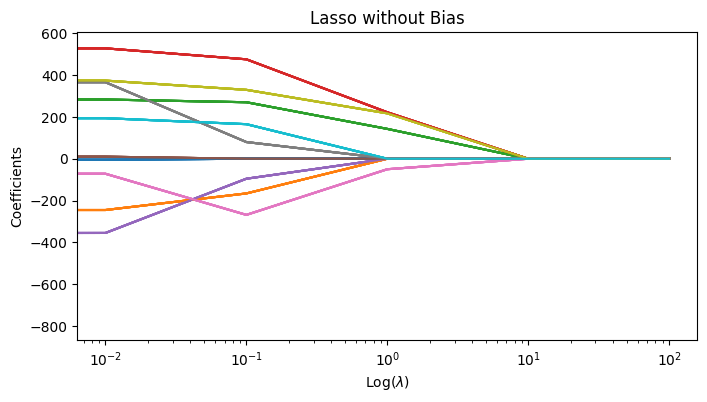

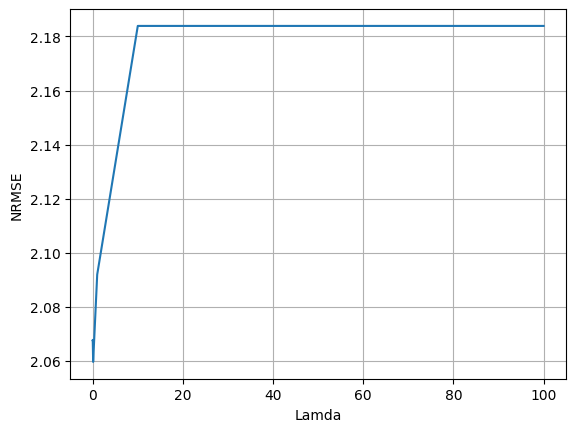

In [8]:
w_wo = []
r2_scores_wo= []
NRMSE_wo = []

for i in lamda:
    model = CoordinateDescentLassoWithoutBias(i)
    model.fit(X_train,Y_train)
    
    w_wo.append(model.coef)
    ym_wo = model.predict(X_test)
    r2_scores_wo.append(r2_score(Y_test,ym_wo))
    NRMSE_wo.append(model.NRMSE(Y_test,ym_wo)) 

df_wo = pd.DataFrame(w_wo)
df_wo.insert(loc=0,column= 'r2_score',value=r2_scores_wo)
df_wo.insert(loc=0,column= 'NRMSE',value=NRMSE_wo)
df_wo['lamda'] = lamda
df_wo.set_index('lamda')

print(df_wo.head())

nwo,_ = np.array(w_wo).shape
plt.figure(figsize = (8,4))

for i in range(nwo):
    plt.plot(lamda, w_wo)

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('Coefficients')
plt.title('Lasso without Bias')
plt.axis('tight')
plt.show()

plt.plot(lamda,NRMSE_wo)
plt.xlabel('Lamda')
plt.ylabel('NRMSE')
plt.axis('tight')
plt.grid()
plt.show()
